# Exercise

Modify the VAE implemented in the notebook replacing the dense layers by convolution (do not forget to use the transposed convolutions in the decoder).


1. First train it using latent dimension 2. How are the images compared to the dense VAE?


2. Increase the latent dimension to 50. What changed?


3. For each latent dimension, monitor how the histogram of the output of the encoder evolves during training. Do they look like standard normal distributions?

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils import reset_seed, display_compare

import os

tf.config.experimental.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## Exercises 1 and 2

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape, Lambda, Layer, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.nn import leaky_relu

def sampling_fn(inputs):
    mean, log_var = inputs
    eps = tf.random.normal(shape=tf.shape(mean))
    return eps * tf.exp(log_var / 2) + mean

def make_VEncoder(latent_dim, nf):
    
    x = Input(shape=[28, 28])
    hidden = Reshape([28, 28, 1], input_shape=[28, 28])(x)
    hidden = Conv2D(nf, 3, strides=2, padding="same", activation=leaky_relu)(hidden)
    hidden = Conv2D(2*nf, 3, strides=2, padding="same", activation=leaky_relu)(hidden)
    hidden = Flatten()(hidden)
    # Here the magic!
    mean = Dense(latent_dim)(hidden)
    log_var  = Dense(latent_dim)(hidden)
    # Sample from N(z|mean, var)
    codings = Lambda(sampling_fn, name="sampling_layer")([mean, log_var])
    
    encoder = Model(inputs=[x], outputs=[codings, mean, log_var])
    return encoder

def make_VDecoder(latent_dim, nf):
    # As before!
    decoder = Sequential([
        Input(shape=[latent_dim]),
        Dense(7*7*2*nf),
        Reshape([7, 7, 2*nf]),
        Conv2DTranspose(nf, 3, strides=2, padding="same", activation=leaky_relu),
        Conv2DTranspose(1, 3, strides=2, padding="same", activation="sigmoid"),
        Reshape([28, 28])
    ])
    return decoder

def make_VAE(latent_dim=100, first_nf=8, kl_factor=0.0015):
    # create the two models..
    encoder = make_VEncoder(latent_dim, first_nf)
    decoder = make_VDecoder(latent_dim, first_nf)
    
    # Stack them together...
    x = Input(shape=[28, 28])
    codings, mean, log_var = encoder(x)
    reconstruction = decoder(codings)
    VAE = Model(inputs=[x], outputs=[reconstruction])
    
    # Add the extra loss function
    kl_loss = -0.5*tf.reduce_sum(1 + log_var - tf.exp(log_var) - tf.square(mean), axis=-1)
    VAE.add_loss(kl_factor * tf.reduce_mean(kl_loss))
    return VAE

In [3]:
make_VEncoder(2, 8).summary()
make_VDecoder(2, 8).summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 8)    80          reshape[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 16)     1168        conv2d[0][0]                     
______________________________________________________________________________________________

The dimensions match in both: encoder and decoder. For the convolution, the "antilayer" is the transposed convolution for this context.

### Training

In [4]:
from sklearn.model_selection import train_test_split
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train_full = np.float32(x_train_full/255.)
x_test       = np.float32(x_test/255.)
x_train, x_val,  y_train, y_val  = train_test_split(x_train_full, y_train_full, random_state=0)
print(x_train.shape)

(45000, 28, 28)


In [5]:
reset_seed()
vae = make_VAE(2)
vae.compile(loss="binary_crossentropy", optimizer="rmsprop")
vae.fit(x_train, x_train, epochs=25, batch_size=128, validation_data=(x_val, x_val))

Epoch 1/25
352/352 [==============================] - 2s 5ms/step - loss: 0.4722 - val_loss: 0.3943
Epoch 2/25
352/352 [==============================] - 2s 4ms/step - loss: 0.3872 - val_loss: 0.3834
Epoch 3/25
352/352 [==============================] - 2s 4ms/step - loss: 0.3809 - val_loss: 0.3801
Epoch 4/25
352/352 [==============================] - 2s 4ms/step - loss: 0.3769 - val_loss: 0.3751
Epoch 5/25
352/352 [==============================] - 2s 4ms/step - loss: 0.3725 - val_loss: 0.3712
Epoch 6/25
352/352 [==============================] - 2s 4ms/step - loss: 0.3695 - val_loss: 0.3692
Epoch 7/25
352/352 [==============================] - 2s 4ms/step - loss: 0.3674 - val_loss: 0.3668
Epoch 8/25
352/352 [==============================] - 2s 4ms/step - loss: 0.3657 - val_loss: 0.3651
Epoch 9/25
352/352 [==============================] - 2s 4ms/step - loss: 0.3642 - val_loss: 0.3643
Epoch 10/25
352/352 [==============================] - 2s 4ms/step - loss: 0.3630 - val_loss: 0.3639

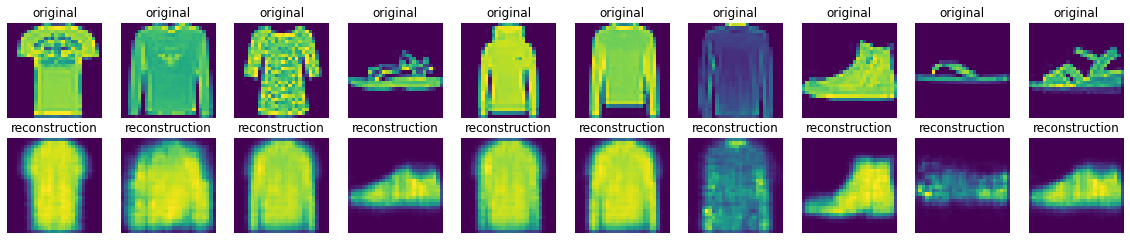

In [6]:
rec_vae = vae.predict(x_val)

display_compare(x_val, rec_vae, names=["original", "reconstruction"])

Dense VAE:

![](img/dense_vae.png)

According to the images, the convolutional (2-layer) VAE shows more blurrier results when using a Latent Dimension of 2, so the results are not better compared to the Dense VAE.

Epoch 1/25
352/352 [==============================] - 2s 5ms/step - loss: 0.4276 - val_loss: 0.3705
Epoch 2/25
352/352 [==============================] - 2s 5ms/step - loss: 0.3564 - val_loss: 0.3473
Epoch 3/25
352/352 [==============================] - 2s 5ms/step - loss: 0.3400 - val_loss: 0.3358
Epoch 4/25
352/352 [==============================] - 2s 5ms/step - loss: 0.3331 - val_loss: 0.3350
Epoch 5/25
352/352 [==============================] - 2s 5ms/step - loss: 0.3299 - val_loss: 0.3289
Epoch 6/25
352/352 [==============================] - 2s 5ms/step - loss: 0.3280 - val_loss: 0.3279
Epoch 7/25
352/352 [==============================] - 2s 5ms/step - loss: 0.3266 - val_loss: 0.3260
Epoch 8/25
352/352 [==============================] - 2s 5ms/step - loss: 0.3256 - val_loss: 0.3262
Epoch 9/25
352/352 [==============================] - 2s 5ms/step - loss: 0.3247 - val_loss: 0.3242
Epoch 10/25
352/352 [==============================] - 2s 5ms/step - loss: 0.3240 - val_loss: 0.3236

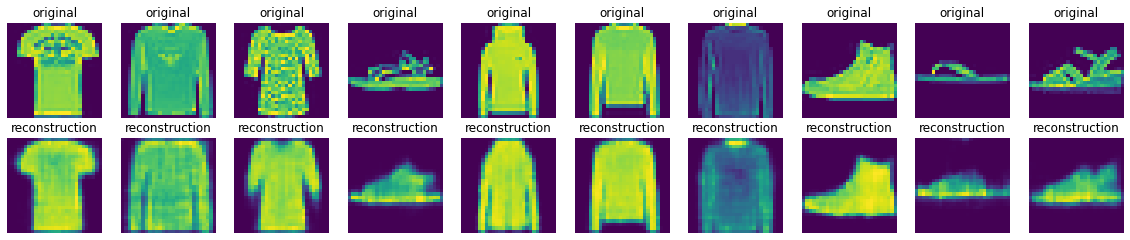

In [7]:
reset_seed()
vae = make_VAE(50)
vae.compile(loss="binary_crossentropy", optimizer="rmsprop")
vae.fit(x_train, x_train, epochs=25, batch_size=128, validation_data=(x_val, x_val))
rec_vae = vae.predict(x_val)

display_compare(x_val, rec_vae, names=["original", "reconstruction"])

For a latent dimensionality of 50 DoFs, the predictions are a way better compared to the 2-dimensional case. It is possible to appreciate in the 3rd image, that the prediction improved. In the former cases, the 3rd image was mispredicted.

This leads to the conclusion that the more latent dimensions, the better accuracy. Nevertheless, it comes with the tradeoff of the simplification. The greater the dimensionality, the less is the compression. This balance may be better tuned when using the implicit dimensionality of the study.

In [8]:
v_encoder = vae.layers[1]
codings, *_ = v_encoder(x_val)
codings.shape

TensorShape([15000, 50])

## Exercise 3

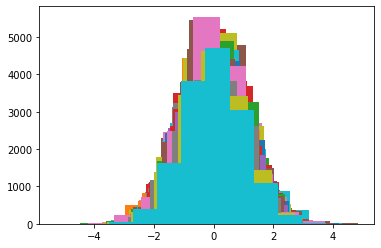

In [9]:
for dim in np.hsplit(codings,50):
    plt.hist(dim)

Yes, they look like Standard Distributions, with mean=0 and std=1, which is according to the definition of the Std Dev and how we are sampling the results